#Introduction

We took our best model up to now, and we decided to perform all separate predictions, to see if something changes (we thought that the training could not have considered the different ranges of the signals). Unfortunately, this didn't improve our results (almost nothing changed with respect to when the seven time series were trained all together).

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2

/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2


In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=136fae3a3ca6dd505a69107e162004ff0d66371732caef15b656e5d32d5edda2
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


# Import libraries

In [ ]:
title = 'Attention_win90st5_allSeparate_1_Sponginess' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('Dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


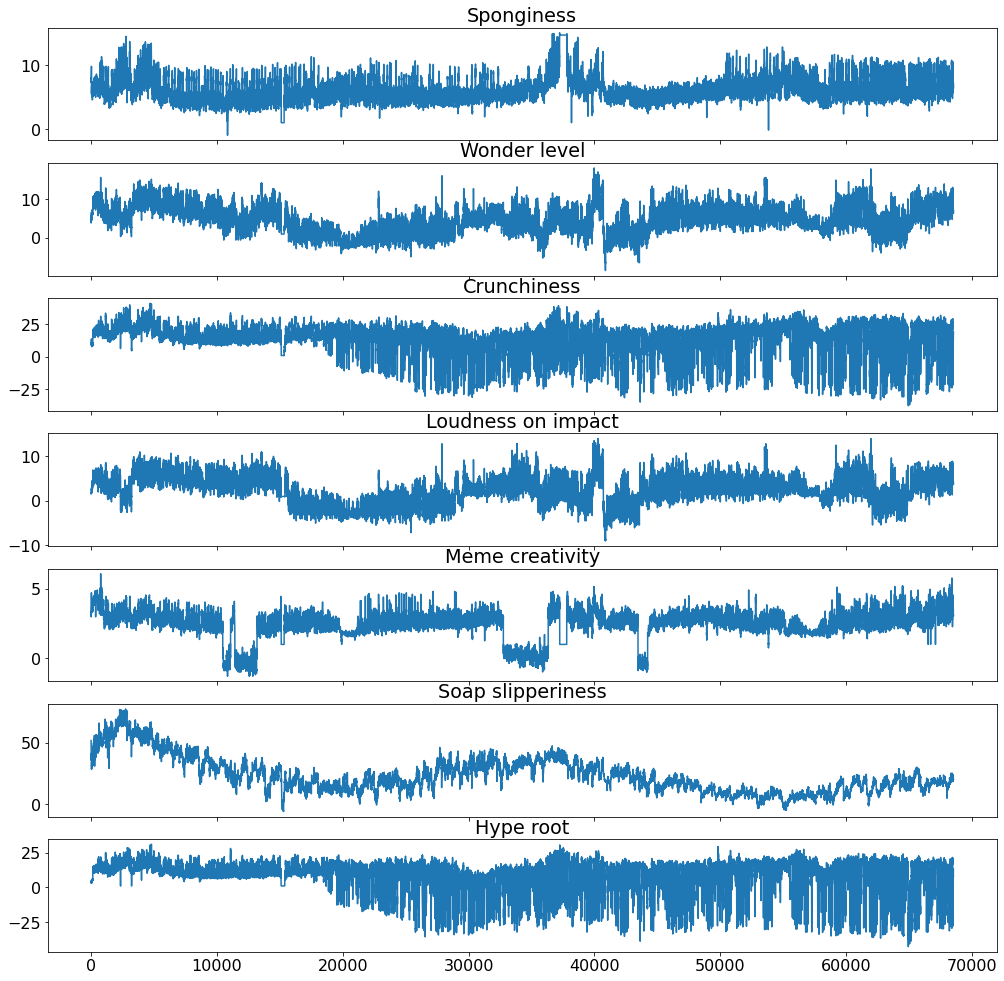

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


(63528, 7) (5000, 7)


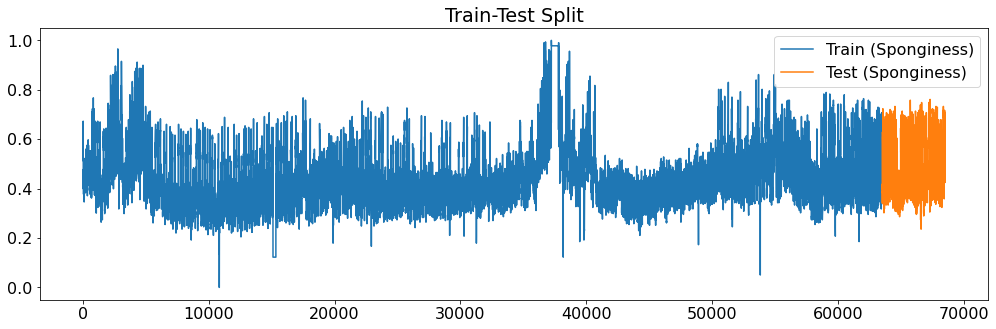

In [ ]:
test_size = 5000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw['Sponginess'], label='Train (Sponginess)')
plt.plot(X_test_raw['Sponginess'], label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)

X_min
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [ ]:
direct_window = 90
direct_stride = 5
ar_window = 90
ar_stride = 5
general_telescope = 864

In [ ]:
future = dataset[-direct_window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
print(future.shape)

(1, 90, 7)


In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=30, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(es2_callback)

  return callbacks

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))
    index_of_column = 0
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,2))
    #for col in enumerate(columns):
    axs.plot(np.arange(len(X[0,:,index_of_column])), X[idx,:,index_of_column])
    axs.scatter(np.arange(len(X[0,:,index_of_column]), len(X_train[0,:,index_of_column])+telescope), y[idx,:], color='orange')
    axs.set_title(columns)
    axs.set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    print(lstm.shape)
    attention = SeqSelfAttention(attention_activation='sigmoid')(lstm)
    print(attention.shape)
    gap = tfkl.GlobalAveragePooling1D()(attention)
    dense = tfkl.Dense(output_shape[0]*output_shape[1], activation='relu')(gap)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    # Connect input and output through the Model class
    full_model = tfk.Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    full_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return full_model

# Forecasting

In [ ]:
target_labels = ['Sponginess']
telescope = 864

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, ar_window, ar_stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, ar_window, ar_stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12518, 90, 7), (12518, 864, 1), (818, 90, 7), (818, 864, 1))

In [ ]:
#inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 8
epochs = 500

In [ ]:
print(input_shape, output_shape)

(90, 7) (864, 1)


(None, 90, 512)
(None, 90, 512)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 90, 7)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 90, 512)          540672    
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, 90, 512)          32833     
 Attention)                                                      
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 864)               443232    
                             

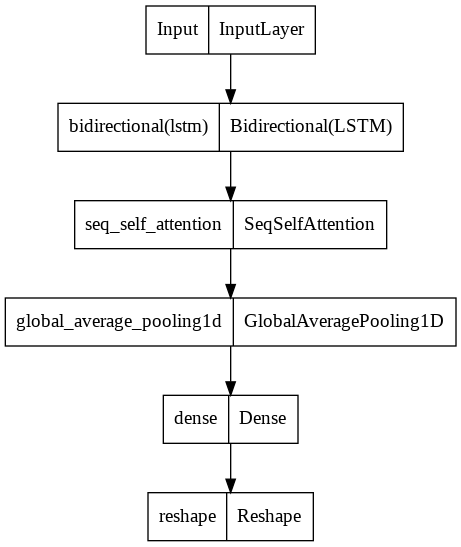

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

# Training and testing

In [ ]:
# Create folders and callbacks and fit
cbs = create_folders_and_callbacks(model_name = title) #the model name will generate the folder of this single experiment

# restore checkpoints:
#model.load_weights('/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2/Check/+'title'+_datetime/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
#In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = cbs
).history

Epoch 1/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0496 - mae: 0.1514 - rmse: 0.2227

1409/1409 [==============================] - 57s 31ms/step - loss: 0.0496 - mae: 0.1514 - rmse: 0.2227 - val_loss: 0.0453 - val_mae: 0.1492 - val_rmse: 0.2128 - lr: 0.0010
Epoch 2/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0352 - mae: 0.1230 - rmse: 0.1876

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0352 - mae: 0.1230 - rmse: 0.1876 - val_loss: 0.0327 - val_mae: 0.1264 - val_rmse: 0.1809 - lr: 0.0010
Epoch 3/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0279 - mae: 0.1089 - rmse: 0.1671

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0279 - mae: 0.1090 - rmse: 0.1671 - val_loss: 0.0299 - val_mae: 0.1215 - val_rmse: 0.1728 - lr: 0.0010
Epoch 4/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0255 - mae: 0.1042 - rmse: 0.1598

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0255 - mae: 0.1042 - rmse: 0.1598 - val_loss: 0.0286 - val_mae: 0.1171 - val_rmse: 0.1691 - lr: 0.0010
Epoch 5/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0220 - mae: 0.0973 - rmse: 0.1482

1409/1409 [==============================] - 44s 31ms/step - loss: 0.0220 - mae: 0.0973 - rmse: 0.1482 - val_loss: 0.0242 - val_mae: 0.1109 - val_rmse: 0.1555 - lr: 0.0010
Epoch 6/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0190 - mae: 0.0915 - rmse: 0.1378

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0190 - mae: 0.0914 - rmse: 0.1377 - val_loss: 0.0224 - val_mae: 0.1060 - val_rmse: 0.1498 - lr: 0.0010
Epoch 7/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0179 - mae: 0.0892 - rmse: 0.1339

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0179 - mae: 0.0892 - rmse: 0.1339 - val_loss: 0.0223 - val_mae: 0.1058 - val_rmse: 0.1493 - lr: 0.0010
Epoch 8/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0165 - mae: 0.0862 - rmse: 0.1286

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0165 - mae: 0.0862 - rmse: 0.1286 - val_loss: 0.0203 - val_mae: 0.1058 - val_rmse: 0.1426 - lr: 0.0010
Epoch 9/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0157 - mae: 0.0844 - rmse: 0.1255

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0157 - mae: 0.0844 - rmse: 0.1255 - val_loss: 0.0191 - val_mae: 0.1059 - val_rmse: 0.1381 - lr: 0.0010
Epoch 10/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0144 - mae: 0.0814 - rmse: 0.1202

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0144 - mae: 0.0814 - rmse: 0.1202 - val_loss: 0.0179 - val_mae: 0.1006 - val_rmse: 0.1339 - lr: 0.0010
Epoch 11/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0130 - mae: 0.0784 - rmse: 0.1141

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0130 - mae: 0.0784 - rmse: 0.1141 - val_loss: 0.0171 - val_mae: 0.0976 - val_rmse: 0.1307 - lr: 0.0010
Epoch 12/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0124 - mae: 0.0762 - rmse: 0.1115

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0124 - mae: 0.0762 - rmse: 0.1114 - val_loss: 0.0167 - val_mae: 0.0958 - val_rmse: 0.1291 - lr: 0.0010
Epoch 13/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0120 - mae: 0.0744 - rmse: 0.1094

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0120 - mae: 0.0744 - rmse: 0.1094 - val_loss: 0.0167 - val_mae: 0.0946 - val_rmse: 0.1292 - lr: 0.0010
Epoch 14/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0117 - mae: 0.0732 - rmse: 0.1082

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0117 - mae: 0.0732 - rmse: 0.1082 - val_loss: 0.0163 - val_mae: 0.0955 - val_rmse: 0.1276 - lr: 0.0010
Epoch 15/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0109 - mae: 0.0717 - rmse: 0.1046

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0109 - mae: 0.0717 - rmse: 0.1046 - val_loss: 0.0153 - val_mae: 0.0925 - val_rmse: 0.1236 - lr: 0.0010
Epoch 16/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0103 - mae: 0.0695 - rmse: 0.1015

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0103 - mae: 0.0695 - rmse: 0.1015 - val_loss: 0.0153 - val_mae: 0.0938 - val_rmse: 0.1237 - lr: 0.0010
Epoch 17/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0100 - mae: 0.0685 - rmse: 0.0998

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0100 - mae: 0.0685 - rmse: 0.0998 - val_loss: 0.0153 - val_mae: 0.0940 - val_rmse: 0.1235 - lr: 0.0010
Epoch 18/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0098 - mae: 0.0678 - rmse: 0.0990

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0098 - mae: 0.0678 - rmse: 0.0990 - val_loss: 0.0152 - val_mae: 0.0940 - val_rmse: 0.1233 - lr: 0.0010
Epoch 19/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0095 - mae: 0.0667 - rmse: 0.0975

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0095 - mae: 0.0667 - rmse: 0.0975 - val_loss: 0.0149 - val_mae: 0.0915 - val_rmse: 0.1221 - lr: 0.0010
Epoch 20/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0090 - mae: 0.0656 - rmse: 0.0951

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0090 - mae: 0.0656 - rmse: 0.0951 - val_loss: 0.0152 - val_mae: 0.0933 - val_rmse: 0.1232 - lr: 0.0010
Epoch 21/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0084 - mae: 0.0640 - rmse: 0.0918

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0084 - mae: 0.0640 - rmse: 0.0918 - val_loss: 0.0135 - val_mae: 0.0910 - val_rmse: 0.1164 - lr: 0.0010
Epoch 22/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0082 - mae: 0.0641 - rmse: 0.0907

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0082 - mae: 0.0641 - rmse: 0.0907 - val_loss: 0.0151 - val_mae: 0.0917 - val_rmse: 0.1227 - lr: 0.0010
Epoch 23/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0077 - mae: 0.0627 - rmse: 0.0879

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0077 - mae: 0.0627 - rmse: 0.0879 - val_loss: 0.0139 - val_mae: 0.0919 - val_rmse: 0.1179 - lr: 0.0010
Epoch 24/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0073 - mae: 0.0613 - rmse: 0.0856

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0073 - mae: 0.0613 - rmse: 0.0856 - val_loss: 0.0140 - val_mae: 0.0901 - val_rmse: 0.1182 - lr: 0.0010
Epoch 25/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0074 - mae: 0.0616 - rmse: 0.0861

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0074 - mae: 0.0616 - rmse: 0.0861 - val_loss: 0.0140 - val_mae: 0.0935 - val_rmse: 0.1184 - lr: 0.0010
Epoch 26/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0600 - rmse: 0.0840

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0070 - mae: 0.0600 - rmse: 0.0840 - val_loss: 0.0135 - val_mae: 0.0881 - val_rmse: 0.1162 - lr: 0.0010
Epoch 27/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0070 - mae: 0.0600 - rmse: 0.0839

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0070 - mae: 0.0600 - rmse: 0.0839 - val_loss: 0.0137 - val_mae: 0.0915 - val_rmse: 0.1170 - lr: 0.0010
Epoch 28/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0601 - rmse: 0.0842

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0071 - mae: 0.0601 - rmse: 0.0842 - val_loss: 0.0141 - val_mae: 0.0895 - val_rmse: 0.1187 - lr: 0.0010
Epoch 29/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0068 - mae: 0.0588 - rmse: 0.0824

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0068 - mae: 0.0588 - rmse: 0.0824 - val_loss: 0.0143 - val_mae: 0.0892 - val_rmse: 0.1194 - lr: 0.0010
Epoch 30/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0600 - rmse: 0.0842

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0071 - mae: 0.0600 - rmse: 0.0842 - val_loss: 0.0141 - val_mae: 0.0909 - val_rmse: 0.1186 - lr: 0.0010
Epoch 31/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0602 - rmse: 0.0845

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0071 - mae: 0.0602 - rmse: 0.0845 - val_loss: 0.0137 - val_mae: 0.0924 - val_rmse: 0.1169 - lr: 0.0010
Epoch 32/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0575 - rmse: 0.0809

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0065 - mae: 0.0575 - rmse: 0.0809 - val_loss: 0.0141 - val_mae: 0.0909 - val_rmse: 0.1186 - lr: 5.0000e-04
Epoch 33/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0062 - mae: 0.0562 - rmse: 0.0786

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0062 - mae: 0.0562 - rmse: 0.0786 - val_loss: 0.0134 - val_mae: 0.0893 - val_rmse: 0.1158 - lr: 5.0000e-04
Epoch 34/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0548 - rmse: 0.0756

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0057 - mae: 0.0548 - rmse: 0.0756 - val_loss: 0.0141 - val_mae: 0.0899 - val_rmse: 0.1186 - lr: 5.0000e-04
Epoch 35/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0545 - rmse: 0.0752

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0057 - mae: 0.0545 - rmse: 0.0752 - val_loss: 0.0141 - val_mae: 0.0916 - val_rmse: 0.1186 - lr: 5.0000e-04
Epoch 36/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0541 - rmse: 0.0745

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0055 - mae: 0.0540 - rmse: 0.0745 - val_loss: 0.0143 - val_mae: 0.0907 - val_rmse: 0.1195 - lr: 5.0000e-04
Epoch 37/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0539 - rmse: 0.0743

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0055 - mae: 0.0539 - rmse: 0.0743 - val_loss: 0.0140 - val_mae: 0.0909 - val_rmse: 0.1184 - lr: 5.0000e-04
Epoch 38/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0535 - rmse: 0.0737

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0054 - mae: 0.0535 - rmse: 0.0737 - val_loss: 0.0142 - val_mae: 0.0915 - val_rmse: 0.1190 - lr: 5.0000e-04
Epoch 39/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0522 - rmse: 0.0719

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0052 - mae: 0.0522 - rmse: 0.0719 - val_loss: 0.0141 - val_mae: 0.0912 - val_rmse: 0.1188 - lr: 2.5000e-04
Epoch 40/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0519 - rmse: 0.0716

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0051 - mae: 0.0519 - rmse: 0.0716 - val_loss: 0.0141 - val_mae: 0.0914 - val_rmse: 0.1186 - lr: 2.5000e-04
Epoch 41/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0517 - rmse: 0.0713

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0051 - mae: 0.0517 - rmse: 0.0713 - val_loss: 0.0142 - val_mae: 0.0906 - val_rmse: 0.1193 - lr: 2.5000e-04
Epoch 42/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0514 - rmse: 0.0708

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0050 - mae: 0.0514 - rmse: 0.0708 - val_loss: 0.0145 - val_mae: 0.0912 - val_rmse: 0.1204 - lr: 2.5000e-04
Epoch 43/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0512 - rmse: 0.0705

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0050 - mae: 0.0512 - rmse: 0.0705 - val_loss: 0.0143 - val_mae: 0.0915 - val_rmse: 0.1197 - lr: 2.5000e-04
Epoch 44/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0505 - rmse: 0.0696

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0048 - mae: 0.0505 - rmse: 0.0696 - val_loss: 0.0145 - val_mae: 0.0925 - val_rmse: 0.1205 - lr: 1.2500e-04
Epoch 45/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0503 - rmse: 0.0693

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0048 - mae: 0.0503 - rmse: 0.0693 - val_loss: 0.0145 - val_mae: 0.0922 - val_rmse: 0.1204 - lr: 1.2500e-04
Epoch 46/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0502 - rmse: 0.0692

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0048 - mae: 0.0502 - rmse: 0.0692 - val_loss: 0.0145 - val_mae: 0.0925 - val_rmse: 0.1206 - lr: 1.2500e-04
Epoch 47/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0500 - rmse: 0.0689

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0047 - mae: 0.0500 - rmse: 0.0689 - val_loss: 0.0145 - val_mae: 0.0922 - val_rmse: 0.1203 - lr: 1.2500e-04
Epoch 48/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0499 - rmse: 0.0687

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0047 - mae: 0.0499 - rmse: 0.0687 - val_loss: 0.0145 - val_mae: 0.0925 - val_rmse: 0.1203 - lr: 1.2500e-04
Epoch 49/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0495 - rmse: 0.0682

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0046 - mae: 0.0495 - rmse: 0.0682 - val_loss: 0.0145 - val_mae: 0.0928 - val_rmse: 0.1205 - lr: 6.2500e-05
Epoch 50/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0494 - rmse: 0.0681

1409/1409 [==============================] - 42s 30ms/step - loss: 0.0046 - mae: 0.0494 - rmse: 0.0681 - val_loss: 0.0146 - val_mae: 0.0928 - val_rmse: 0.1207 - lr: 6.2500e-05
Epoch 51/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0494 - rmse: 0.0679

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0046 - mae: 0.0494 - rmse: 0.0679 - val_loss: 0.0147 - val_mae: 0.0930 - val_rmse: 0.1212 - lr: 6.2500e-05
Epoch 52/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0493 - rmse: 0.0678

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0046 - mae: 0.0493 - rmse: 0.0678 - val_loss: 0.0147 - val_mae: 0.0930 - val_rmse: 0.1211 - lr: 6.2500e-05
Epoch 53/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0492 - rmse: 0.0677

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0046 - mae: 0.0492 - rmse: 0.0677 - val_loss: 0.0146 - val_mae: 0.0933 - val_rmse: 0.1210 - lr: 6.2500e-05
Epoch 54/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0490 - rmse: 0.0675

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0046 - mae: 0.0490 - rmse: 0.0675 - val_loss: 0.0145 - val_mae: 0.0929 - val_rmse: 0.1206 - lr: 3.1250e-05
Epoch 55/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0490 - rmse: 0.0674

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0045 - mae: 0.0490 - rmse: 0.0674 - val_loss: 0.0145 - val_mae: 0.0929 - val_rmse: 0.1206 - lr: 3.1250e-05
Epoch 56/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0489 - rmse: 0.0673

1409/1409 [==============================] - 43s 30ms/step - loss: 0.0045 - mae: 0.0489 - rmse: 0.0673 - val_loss: 0.0146 - val_mae: 0.0931 - val_rmse: 0.1207 - lr: 3.1250e-05
Epoch 57/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0489 - rmse: 0.0673

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0045 - mae: 0.0489 - rmse: 0.0673 - val_loss: 0.0146 - val_mae: 0.0930 - val_rmse: 0.1209 - lr: 3.1250e-05
Epoch 58/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0488 - rmse: 0.0672

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0045 - mae: 0.0488 - rmse: 0.0672 - val_loss: 0.0146 - val_mae: 0.0930 - val_rmse: 0.1208 - lr: 3.1250e-05
Epoch 59/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0488 - rmse: 0.0671

1409/1409 [==============================] - 44s 31ms/step - loss: 0.0045 - mae: 0.0488 - rmse: 0.0671 - val_loss: 0.0147 - val_mae: 0.0933 - val_rmse: 0.1212 - lr: 1.5625e-05
Epoch 60/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0487 - rmse: 0.0670

1409/1409 [==============================] - 44s 31ms/step - loss: 0.0045 - mae: 0.0487 - rmse: 0.0670 - val_loss: 0.0146 - val_mae: 0.0931 - val_rmse: 0.1210 - lr: 1.5625e-05
Epoch 61/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0487 - rmse: 0.0670

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0045 - mae: 0.0487 - rmse: 0.0670 - val_loss: 0.0147 - val_mae: 0.0932 - val_rmse: 0.1211 - lr: 1.5625e-05
Epoch 62/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0487 - rmse: 0.0670

1409/1409 [==============================] - 43s 31ms/step - loss: 0.0045 - mae: 0.0487 - rmse: 0.0670 - val_loss: 0.0147 - val_mae: 0.0932 - val_rmse: 0.1211 - lr: 1.5625e-05
Epoch 63/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0487 - rmse: 0.0670

1409/1409 [==============================] - 44s 31ms/step - loss: 0.0045 - mae: 0.0487 - rmse: 0.0670 - val_loss: 0.0147 - val_mae: 0.0933 - val_rmse: 0.1213 - lr: 1.5625e-05


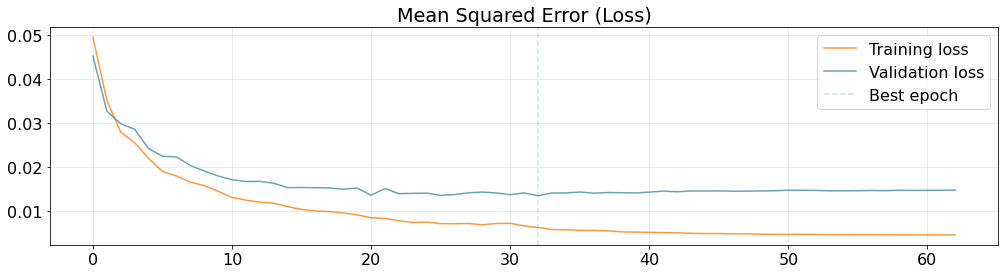

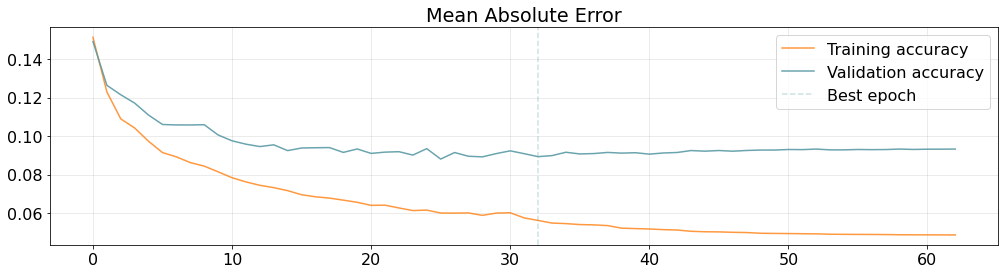

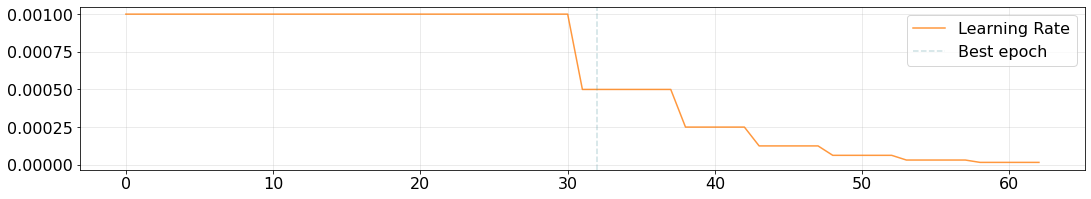

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('Models/'+title)
#model = tfk.models.load_model('Models/'+title)

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(818, 864, 1)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.017897828>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.101192676>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))
    index_of_column = 0
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,2))
    #for i, col in enumerate(columns):
    axs.plot(np.arange(len(X[0,:,index_of_column])), X[idx,:,index_of_column])
    axs.plot(np.arange(len(X[0,:,index_of_column]), len(X_train[0,:,index_of_column])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:,index_of_column]), len(X_train[0,:,index_of_column])+telescope), pred[idx,:], color='green')
    axs.set_title(columns)
    axs.set_ylim(0,1)
    plt.show()

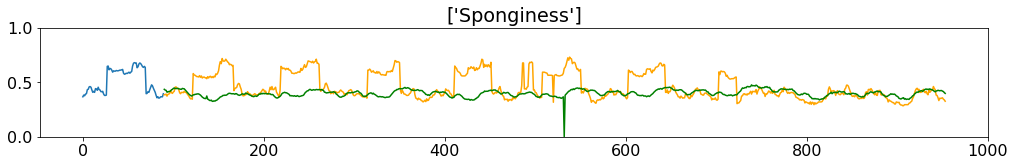

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)